# 0.0 Config

### 0.1 Imports

In [97]:
import re
import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt
from sqlalchemy      import create_engine
from IPython.display import HTML

### 0.2 Helper Function

In [98]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 8]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:97% !important; }</style>') )
    pd.options.display.max_columns = 30
    pd.options.display.max_rows = 30
    pd.options.display.float_format = lambda x: f'{x:.2f}'
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set_theme(rc={'figure.figsize': (15, 6)})
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


### 0.3 Data Collection

In [100]:
path = '/home/luizmaycon/Documentos/repos/python_ds_ao_dev/database/'
database = 'database_hm.sqlite'
conn = create_engine( 'sqlite:///' + path + database, echo=False )

In [101]:
query = """
    SELECT * FROM vitrine
"""

In [102]:
df_raw = pd.read_sql( query, con=conn )

# 1.0 Data Description

In [104]:
df1 = df_raw.copy()

### 1.1 Data Dimension

In [7]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 367
Number of cols: 13


### 1.2 Data Types

In [8]:
df1.dtypes

product_id          object
style_id            object
color_id            object
product_name        object
product_color       object
product_fit         object
product_price      float64
size_number         object
size_model          object
cotton             float64
polyester          float64
spandex            float64
scrapy_datetime     object
dtype: object

In [9]:
# convert object to datetime
df1['scrapy_datetime'] = pd.to_datetime( df1['scrapy_datetime'] )

### 1.3 Missing Data

In [10]:
# amount of missing data
df1.isna().sum()

product_id           0
style_id             0
color_id             0
product_name         0
product_color        0
product_fit          0
product_price        0
size_number        159
size_model         187
cotton               0
polyester            0
spandex              0
scrapy_datetime      0
dtype: int64

In [11]:
# percentage of missing data
df1.isna().sum() / df1.shape[0] * 100

product_id         0.00
style_id           0.00
color_id           0.00
product_name       0.00
product_color      0.00
product_fit        0.00
product_price      0.00
size_number       43.32
size_model        50.95
cotton             0.00
polyester          0.00
spandex            0.00
scrapy_datetime    0.00
dtype: float64

In [12]:
# remove size columns
df1 = df1.drop( columns=['size_number', 'size_model'] )

### 1.4 Numeric Data Description

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )

# central tendency
t1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
t2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concat
ndd = pd.concat( [d2, d3, d4, t1, t2, d1, d5, d6] ).T.reset_index()
ndd.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ndd

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,product_price,5.99,49.99,44.00,31.18,29.99,10.23,-0.30,-0.75
1,cotton,0.99,0.99,0.00,0.99,0.99,0.00,0.00,0.00
2,polyester,0.00,1.00,1.00,0.40,0.65,0.40,0.13,-1.71
3,spandex,0.01,0.01,0.00,0.01,0.01,0.00,0.00,0.00


### 1.5 Categorical Data Description

In [15]:
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
cat_attributes.apply( lambda x: x.unique().shape[0] )

product_id       187
style_id          28
color_id          48
product_name      17
product_color     33
product_fit        5
dtype: int64

# 2.0 Feature Engineering

In [16]:
df2 = df1.copy()

In [17]:
# general color
df2['general_color'] = df2['product_color'].apply( lambda x: re.search( '^[a-z]+$|_[a-z]+$|[a-z]+\/|black', x ).group(0)
                                                  .replace( '_', '' ).replace( '/', '' ) if pd.notnull( x ) else x)

# product color
df2['product_color'] = df2['product_color'].apply( lambda x: x.replace( 'denim_', '' ) )

# transform composition in binary
df2['cotton'] = df2['cotton'].apply(lambda x: 1 if x > 0 else 0)
df2['polyester'] = df2['polyester'].apply(lambda x: 1 if x > 0 else 0)
df2['spandex'] = df2['spandex'].apply(lambda x: 1 if x > 0 else 0)

# 3.0 Attribute Filtering

In [18]:
df3 = df2.copy()

# 4.0 EDA (Exploration Data Analysis)

In [19]:
df4 =  df3.copy()

## 4.1 Hypotheses

- 01- 70% das calças são das cores blue ou black (ou suas derivadas)
- 02- Calças de cores blue ou black possuem os maiores preços médios, sendo 10% mais caros que a terceira cor
- 03- Um único fit representa mais de 50% da quantidade de calças
- 04- 70% das calças possuem polyester em sua composição
- 05- O preço médio das calças que possuem polyester está 30% acima do preço médio das que não possuem

Representam 80.11% das calças.


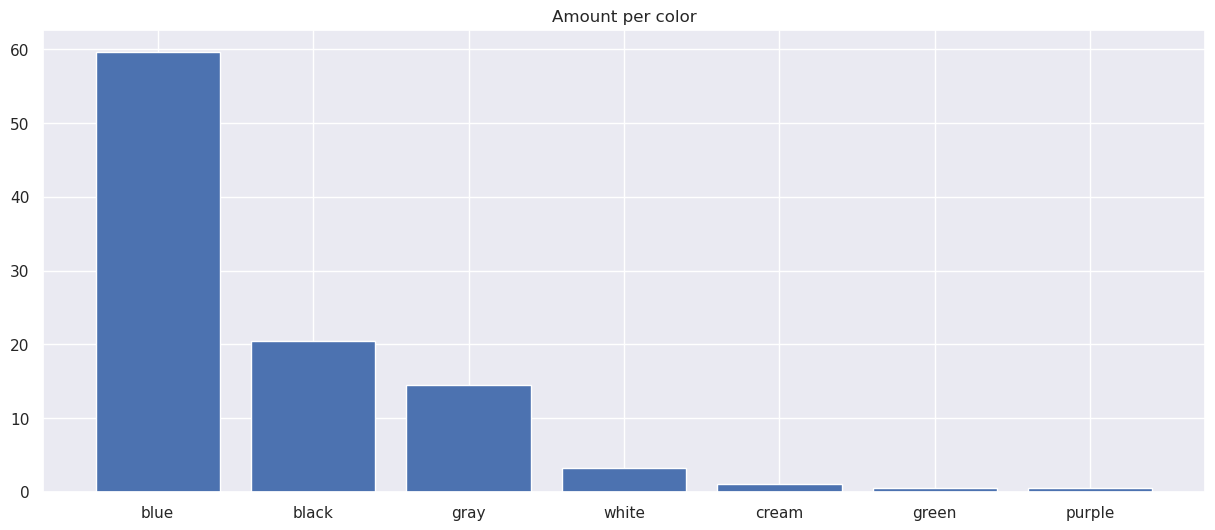

In [20]:
# 01- 70% das calças são das cores blue ou black (ou suas derivadas)
h1 = df4[['general_color', 'product_id']].groupby( 'general_color' ).count().sort_values( 'product_id', ascending=False ).reset_index()

result = round( ( h1.iloc[0, 1] + h1.iloc[1, 1] ) / h1['product_id'].sum() * 100, 2)
print( 'Representam {}% das calças.'.format( result ) )

h1['product_id'] = h1['product_id'].apply( lambda x: x / h1['product_id'].sum() * 100 )

plt.bar( h1['general_color'], h1['product_id'] )
plt.title( 'Amount per color' )
plt.show()

Estão, na verdade, 21.39% abaixo do preço médio mais alto e 15.05% acima do mais baixo.


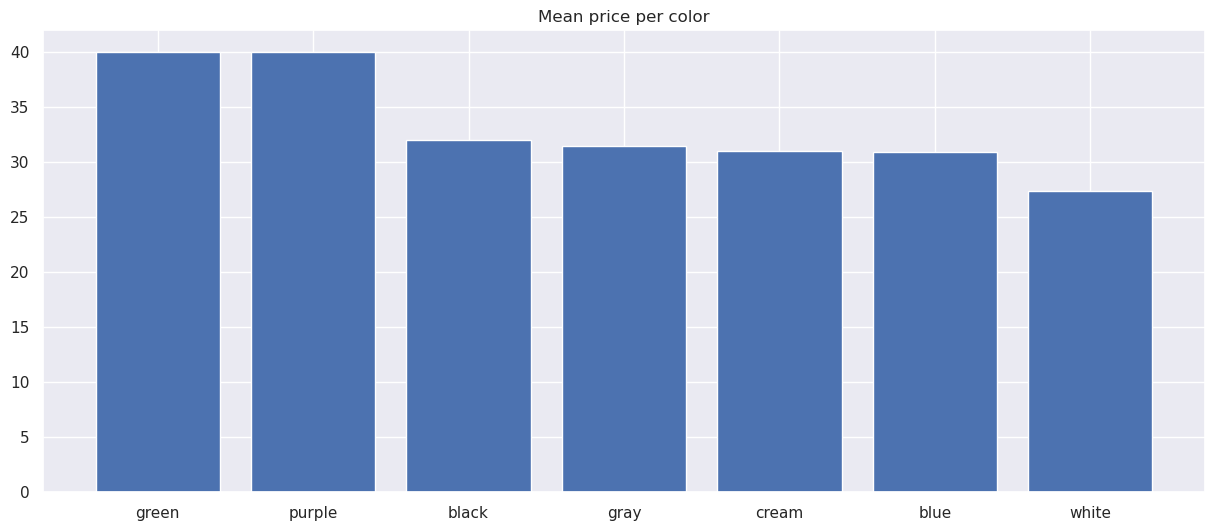

In [65]:
# 02- Calças de cores blue ou black possuem os maiores preços médios, sendo 10% mais caros que a terceira cor
h2 = df4[['general_color', 'product_price']].groupby( 'general_color' ).mean().sort_values( 'product_price', ascending=False ).reset_index()

result1 = round( ( 1 - h2.loc[(h2['general_color'] == 'black') | (h2['general_color'] == 'blue'), 'product_price'].sum() / 2 / h2.iloc[0,1] ) * 100, 2 )
result2 = round( ( h2.loc[(h2['general_color'] == 'black') | (h2['general_color'] == 'blue'), 'product_price'].sum() / 2 / h2.iloc[6,1] - 1) * 100, 2 )
print( 'Estão, na verdade, {}% abaixo do preço médio mais alto e {}% acima do mais baixo.'.format( result1, result2 ) )

plt.bar( h2['general_color'], h2['product_price'] )
plt.title( 'Mean price per color' )
plt.show()

O regular_fit, que possui a maior quantidade de calça, possui 29.43% do total.


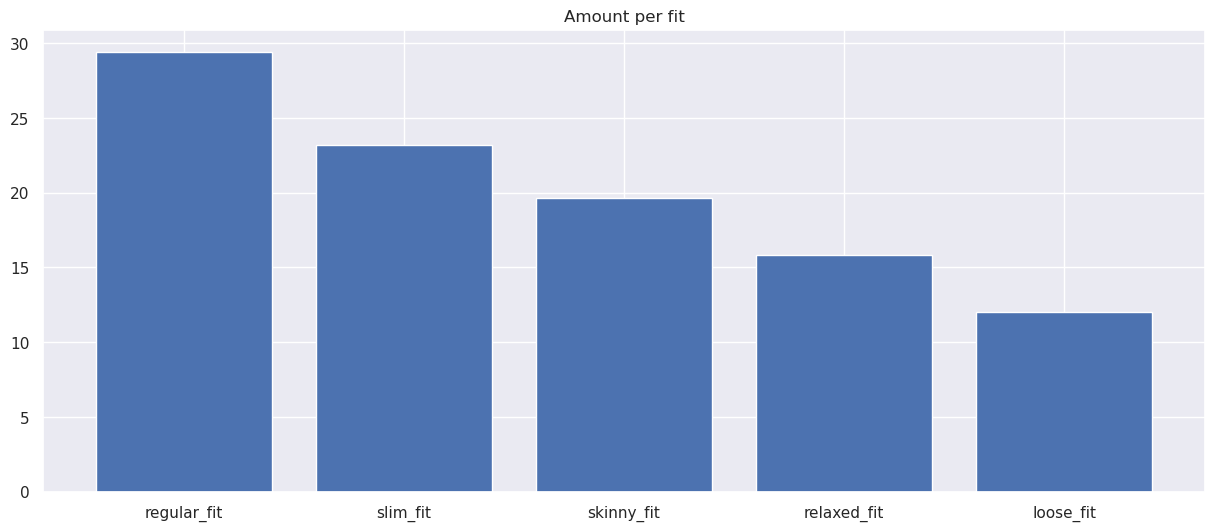

In [66]:
# 03- Um único fit representa mais de 50% da quantidade de calças
h3 = df4[['product_fit', 'product_id']].groupby( 'product_fit' ).count().sort_values( 'product_id', ascending=False ).reset_index()

result = round( h3.iloc[0,1] / h3['product_id'].sum() * 100, 2 )
print( 'O {}, que possui a maior quantidade de calça, possui {}% do total.'.format( h3.iloc[0,0], result ) )

h3['product_id'] = h3['product_id'].apply( lambda x: x / h3['product_id'].sum() * 100 )

plt.bar( h3['product_fit'], h3['product_id'] )
plt.title( 'Amount per fit' )
plt.show()

Apenas 51.77% das calças possuem polyester.


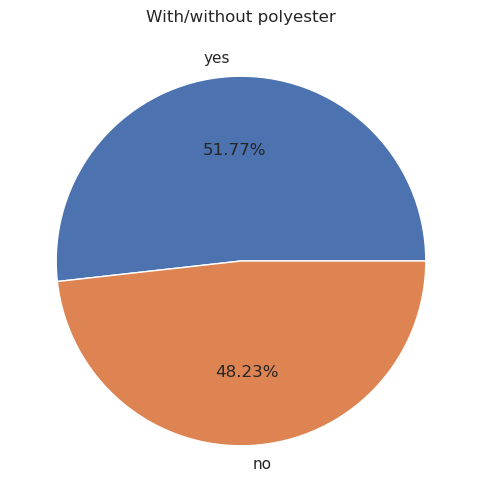

In [67]:
# 04- 70% das calças possuem polyester em sua composição
h4 = df4[['polyester', 'product_id']].groupby( 'polyester' ).count().reset_index()

result = round( h4.iloc[1,1] / h4['product_id'].sum() * 100, 2 )
print( 'Apenas {}% das calças possuem polyester.'.format( result ) )

plt.pie( [h4.iloc[1,1], h4.iloc[0,1]],labels = ['yes', 'no'], autopct='%.2f%%' )
plt.title( 'With/without polyester' )
plt.show()

Na verdade, está 0.01% abaixo.


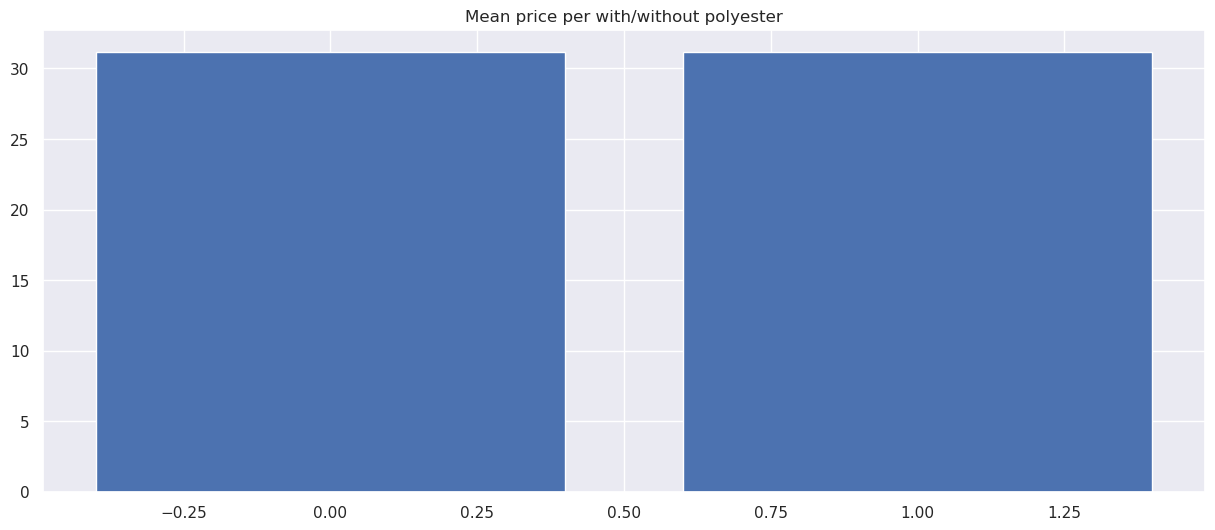

In [24]:
# 05- O preço médio das calças que possuem polyester está 30% acima do preço médio das que não possuem
h5 = df4[['polyester', 'product_price']].groupby( 'polyester' ).mean().reset_index()

result = round( ( 1 - h5.iloc[1,1] /h5.iloc[0,1] ) * 100 , 2 )
print( 'Na verdade, está {}% abaixo.'.format( result ) )

plt.bar( h5['polyester'], h5['product_price'] )
plt.title( 'Mean price per with/without polyester' )
plt.show()

## 4.2 Answering Business Questions

- 1. Qual o melhor preço de venda para as calças?
- 2. Quantos tipos de calças e suas cores para o produto inicial?
- 3. Quais as matérias-prima necessárias para confeccionar as calças?

In [68]:
# 01 amount for blue e black varitations
# 02 mean price per fit

In [69]:
df4.loc[df4['scrapy_datetime'] > '2023-01-09 10:15:23']

,product_id,style_id,color_id,product_name,product_color,product_fit,product_price,cotton,polyester,spandex,scrapy_datetime,general_color
0,1024256001,1024256,001,slim_jeans,black,slim_fit,24.99,1,1,1,2023-01-09 12:48:50,black
1,1024256002,1024256,002,slim_jeans,light_blue,slim_fit,24.99,1,1,1,2023-01-09 12:48:50,blue
2,1024256003,1024256,003,slim_jeans,light_blue,slim_fit,24.99,1,1,1,2023-01-09 12:48:50,blue
3,1024256004,1024256,004,slim_jeans,blue,slim_fit,24.99,1,1,1,2023-01-09 12:48:50,blue
4,1024256005,1024256,005,slim_jeans,dark_blue,slim_fit,24.99,1,1,1,2023-01-09 12:48:50,blue
...,...,...,...,...,...,...,...,...,...,...,...,...
362,0927964013,0927964,013,regular_tapered_crop_jeans,black,regular_fit,19.99,1,0,1,2023-01-10 10:25:42,black
363,1063141001,1063141,001,loose_jeans,blue,loose_fit,44.99,1,0,1,2023-01-10 10:25:42,blue
364,1051644001,1051644,001,loose_jeans,blue,loose_fit,44.99,1,0,1,2023-01-10 10:25:42,blue
365,1025726002,1025726,002,relaxed_jeans,light_blue,relaxed_fit,11.99,1,0,1,2023-01-10 10:25:42,blue


In [70]:
aux_amount = df4.loc[df4['product_color'].str.contains( 'blue', na=True ) | df4['product_color'].str.contains( 'black', na=True ),
        ['product_color', 'product_id']].groupby( 'product_color' ).count().sort_values( 'product_id', ascending=False ).reset_index()
aux_amount.columns = ['color', 'amount']
aux_amount['percentage'] = aux_amount['amount'].apply( lambda x: x / aux_amount['amount'].sum() * 100 )
aux_amount.head(5)

,color,amount,percentage
0,blue,73,24.83
1,light_blue,71,24.15
2,black,57,19.39
3,dark_blue,50,17.01
4,pale_blue,10,3.40


In [71]:
df4[['product_fit', 'product_price']].groupby( 'product_fit' ).mean().sort_values( 'product_price', ascending=False ).reset_index()

,product_fit,product_price
0,loose_fit,39.99
1,relaxed_fit,34.33
2,slim_fit,32.31
3,regular_fit,27.71
4,skinny_fit,27.13


In [72]:
# 01 mean price per color
# 02 mean price per color for only regular fit

In [73]:
aux_price = df4.loc[df4['product_color'].str.contains( 'blue', na=True ) | df4['product_color'].str.contains( 'black', na=True ),
        ['product_color', 'product_price']].groupby( 'product_color' ).mean().sort_values( 'product_price', ascending=False ).reset_index()
aux_price.columns = ['color', 'mean_price']
aux_price.head(10)

,color,mean_price
0,black/no_fade_black,44.99
1,black/patterned,39.99
2,black/trashed,39.99
3,blue,33.11
4,black,32.41
5,pale_blue,32.39
6,dark_blue,31.23
7,light_blue,30.05
8,light_blue/trashed,26.99
9,dark_blue/trashed,23.49


In [74]:
aux_fit = df4.loc[df4['product_fit'] == 'regular_fit', :]
aux_fit = df4.loc[(df4['product_color'].str.contains( 'blue', na=True ) | df4['product_color'].str.contains( 'black', na=True )),
                  ['product_color', 'product_price']].groupby( 'product_color' ).mean().sort_values( 'product_price', ascending=False ).reset_index()
aux_fit.columns = ['color', 'mean_price']
aux_fit.head(10)

,color,mean_price
0,black/no_fade_black,44.99
1,black/patterned,39.99
2,black/trashed,39.99
3,blue,33.11
4,black,32.41
5,pale_blue,32.39
6,dark_blue,31.23
7,light_blue,30.05
8,light_blue/trashed,26.99
9,dark_blue/trashed,23.49


In [75]:
# 01 amount per with/without polyester for both regular fit and skinny_fit
# 02 mean price per with/without polyester for both regular fit and skinny_fit

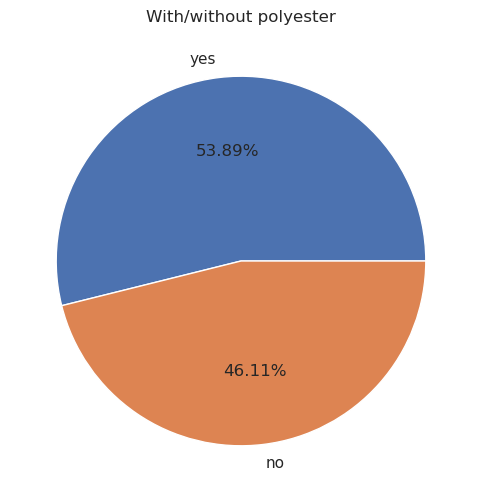

In [76]:
aux_composition = df4.loc[(df4['product_fit'] == 'regular_fit') | (df4['product_fit'] == 'skinny_fit'), :]
aux_composition = aux_composition[['polyester', 'product_id']].groupby( 'polyester' ).count().reset_index()
aux_composition.columns = ['polyester', 'amount']

plt.pie( [aux_composition.iloc[1,1], aux_composition.iloc[0,1]],labels = ['yes', 'no'], autopct='%.2f%%' )
plt.title( 'With/without polyester' )
plt.show()

In [77]:
aux_composition = df4.loc[(df4['product_fit'] == 'regular_fit') | (df4['product_fit'] == 'skinny_fit'), :]
aux_composition = aux_composition[['polyester', 'product_price']].groupby( 'polyester' ).mean().reset_index()
aux_composition.columns = ['polyester', 'mean_price']

result = round( (aux_composition.iloc[0, 1] - aux_composition.iloc[1,1]) / aux_composition.iloc[0,1] * 100, 2 )
print( 'A diferença é de {}%'.format( result ) )

aux_composition

A diferença é de 9.75%


,polyester,mean_price
0,0,29.00
1,1,26.18


In [78]:
# 01 amount per with/without polyester for only regular fit
# 02 mean price per with/without polyester for only regular fit

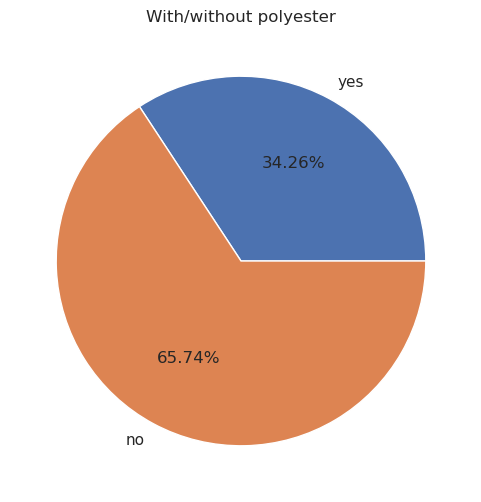

In [79]:
aux_composition = df4.loc[df4['product_fit'] == 'regular_fit', :]
aux_composition = aux_composition[['polyester', 'product_id']].groupby( 'polyester' ).count().reset_index()
aux_composition.columns = ['polyester', 'amount']

plt.pie( [aux_composition.iloc[1,1], aux_composition.iloc[0,1]],labels = ['yes', 'no'], autopct='%.2f%%' )
plt.title( 'With/without polyester' )
plt.show()

In [80]:
aux_composition = df4.loc[df4['product_fit'] == 'regular_fit', :]
aux_composition = aux_composition[['polyester', 'product_price']].groupby( 'polyester' ).mean().reset_index()
aux_composition.columns = ['polyester', 'mean_price']

result = round( (aux_composition.iloc[0, 1] - aux_composition.iloc[1,1]) / aux_composition.iloc[0,1] * 100, 2 )
print( 'A diferença é de {}%'.format( result ) )

aux_composition

A diferença é de 16.48%


,polyester,mean_price
0,0,29.37
1,1,24.53


In [81]:
# 01 amount per with/without polyester for only skinny_fit
# 02 mean price per with/without polyester for only skinny_fit

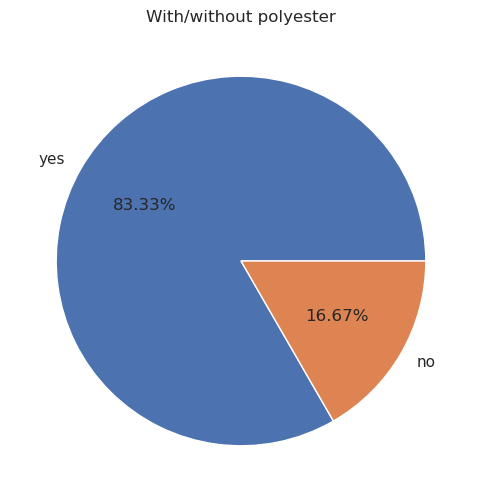

In [94]:
aux_composition = df4.loc[df4['product_fit'] == 'skinny_fit', :]
aux_composition = aux_composition[['polyester', 'product_id']].groupby( 'polyester' ).count().reset_index()
aux_composition.columns = ['polyester', 'amount']

plt.pie( [aux_composition.iloc[1,1], aux_composition.iloc[0,1]],labels = ['yes', 'no'], autopct='%.2f%%' )
plt.title( 'With/without polyester' )
plt.show()

In [93]:
aux_composition = df4.loc[df4['product_fit'] == 'skinny_fit', :]
aux_composition = aux_composition[['polyester', 'product_price']].groupby( 'polyester' ).mean().reset_index()
aux_composition.columns = ['polyester', 'mean_price']

result = round( (aux_composition.iloc[0, 1] - aux_composition.iloc[1,1]) / aux_composition.iloc[0,1] * 100, 2 )
print( 'A diferença é de {}%'.format( result ) )

aux_composition

A diferença é de -1.37%


,polyester,mean_price
0,0,26.82
1,1,27.19


### 4.2.1 Case 01

    fits   -> regular_fit
    colors -> black, blue

In [84]:
case_01 = df4.loc[(df4['product_fit'] == 'regular_fit') &
                  ((df4['product_color'] == 'black') | (df4['product_color'] == 'blue')), :]

In [85]:
print( 'Com polyester:' )
print( 'O preço médio total é ${}'.format( round( case_01['product_price'].mean(), 2 ) ) )
case_01_1 = case_01[['product_fit', 'product_color', 'product_price']].groupby( ['product_fit', 'product_color'] ).mean().reset_index()
case_01_1.columns = ['product_fit', 'color', 'mean_price']
case_01_1

Com polyester:
O preço médio total é $28.79


,product_fit,color,mean_price
0,regular_fit,black,26.55
1,regular_fit,blue,30.63


In [87]:
print( 'Sem polyester:' )
case_01_2 = case_01.loc[case_01['polyester'] == 0, :]
print( 'O preço médio total é ${}'.format( round( case_01_2['product_price'].mean(), 2 ) ) )
case_01_2 = case_01_2[['product_fit', 'product_color', 'product_price']].groupby( ['product_fit', 'product_color'] ).mean().reset_index()
case_01_2.columns = ['product_fit', 'color', 'mean_price']
case_01_2

Sem polyester:
O preço médio total é $29.62


,product_fit,color,mean_price
0,regular_fit,black,26.56
1,regular_fit,blue,32.30


### 4.2.2 Case 02

    fits   -> regular_fit
    colors -> black, blue, dark_blue, light_blue

In [88]:
case_02 = df4.loc[(df4['product_fit'] == 'regular_fit') &
                  ((df4['product_color'] == 'black') | (df4['product_color'] == 'blue') |
                   (df4['product_color'] == 'dark_blue') | (df4['product_color'] == 'light_blue')), :]

In [89]:
print( 'Com polyester:' )
print( 'O preço médio total é ${}'.format( round( case_02['product_price'].mean(), 2 ) ) )
case_02_1 = case_02[['product_fit', 'product_color', 'product_price']].groupby( ['product_fit', 'product_color'] ).mean().reset_index()
case_02_1.columns = ['product_fit', 'color', 'mean_price']
case_02_1

Com polyester:
O preço médio total é $27.99


,product_fit,color,mean_price
0,regular_fit,black,26.55
1,regular_fit,blue,30.63
2,regular_fit,dark_blue,27.79
3,regular_fit,light_blue,26.24


In [90]:
print( 'Sem polyester:' )
case_02_2 = case_02.loc[case_02['polyester'] == 0, :]
print( 'O preço médio total é ${}'.format( round( case_02_2['product_price'].mean(), 2 ) ) )
case_02_2 = case_02_2[['product_fit', 'product_color', 'product_price']].groupby( ['product_fit', 'product_color'] ).mean().reset_index()
case_02_2.columns = ['product_fit', 'color', 'mean_price']
case_02_2

Sem polyester:
O preço médio total é $29.57


,product_fit,color,mean_price
0,regular_fit,black,26.56
1,regular_fit,blue,32.30
2,regular_fit,dark_blue,28.09
3,regular_fit,light_blue,30.89


### 4.2.3 Case 03

    fits   -> regular_fit, skinny_fit
    colors -> black, blue

In [46]:
case_03 = df4.loc[((df4['product_fit'] == 'regular_fit') | (df4['product_fit'] == 'skinny_fit')) &
                  ((df4['product_color'] == 'black') | (df4['product_color'] == 'blue')), :]

In [95]:
print( 'Com polyester:' )
print( 'O preço médio total é ${}'.format( round( case_03['product_price'].mean(), 2 ) ) )
case_03_1 = case_03[['product_fit', 'product_color', 'product_price']].groupby( ['product_fit', 'product_color'] ).mean().reset_index()
case_03_1.columns = ['product_fit', 'color', 'mean_price']
case_03_1

Com polyester:
O preço médio total é $28.49


,product_fit,color,mean_price
0,regular_fit,black,26.55
1,regular_fit,blue,30.63
2,skinny_fit,black,31.66
3,skinny_fit,blue,26.28


In [96]:
print( 'Sem polyester:' )
case_03_2 = case_03.loc[case_03['polyester'] == 0, :]
print( 'O preço médio total é ${}'.format( round( case_03_2['product_price'].mean(), 2 ) ) )
case_03_2 = case_03_2[['product_fit', 'product_color', 'product_price']].groupby( ['product_fit', 'product_color'] ).mean().reset_index()
case_03_2.columns = ['product_fit', 'color', 'mean_price']
case_03_2

Sem polyester:
O preço médio total é $28.63


,product_fit,color,mean_price
0,regular_fit,black,26.56
1,regular_fit,blue,32.30
2,skinny_fit,black,29.99
3,skinny_fit,blue,20.49


In [ ]:
df1.to_csv('database/dataset_hm.csv') 